## Data

The data was extracted from the 1974 Motor Trend US magazine, and comprises fuel consumption and 10 aspects of automobile design and performance for 32 automobiles (1973–74 models).

We are to consider possible differences in miles/gallon (mpg) in some control groups like number of cylinders. 

C:\Users\rgfif\AppData\Local\Temp\ipykernel_23864\3990553866.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cyl', y='mpg', data=mtcars, palette=["#00AFBB", "#E7B800", "#FC4E07"], order=["4", "6", "8"])


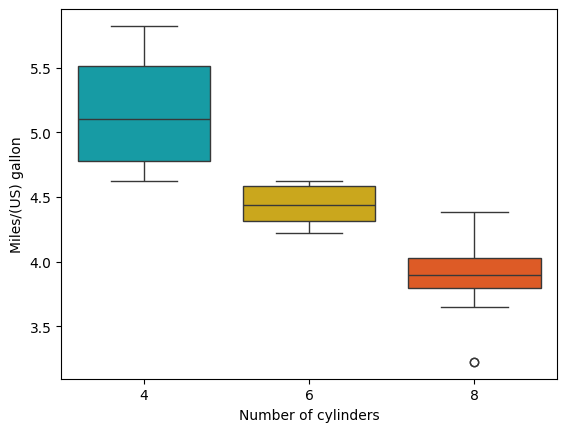

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load the mtcars dataset

url = "https://raw.githubusercontent.com/selva86/datasets/master/mtcars.csv"
mtcars = pd.read_csv(url)
mtcars['cyl'] = mtcars['cyl'].astype(str)

# Create a box plot
sns.boxplot(x='cyl', y='mpg', data=mtcars, palette=["#00AFBB", "#E7B800", "#FC4E07"], order=["4", "6", "8"])

# Add axis labels
plt.xlabel("Number of cylinders")
plt.ylabel("Miles/(US) gallon")

# Show the plot
plt.show()

Let's take a look at confidence intervals first.

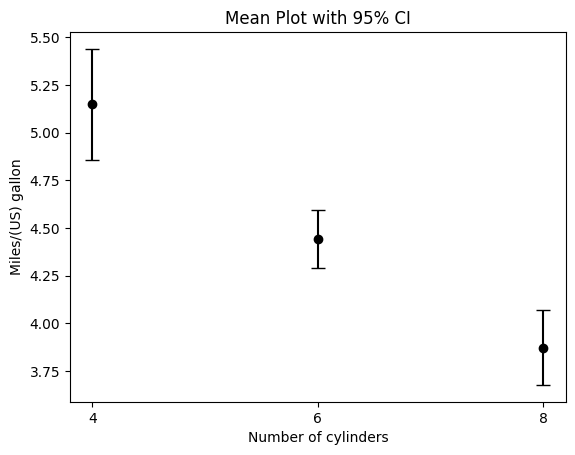

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.weightstats import DescrStatsW

# Calculate means and confidence intervals
means = mtcars.groupby('cyl')['mpg'].mean()
conf_intervals = mtcars.groupby('cyl')['mpg'].apply(lambda x: DescrStatsW(x).tconfint_mean())

# Extract lower and upper bounds of the confidence intervals
lower_bounds = conf_intervals.apply(lambda x: x[0])
upper_bounds = conf_intervals.apply(lambda x: x[1])

# Create the plot
plt.errorbar(means.index, means, yerr=[means - lower_bounds, upper_bounds - means], fmt='o', capsize=5, color='black')
plt.xlabel("Number of cylinders")
plt.ylabel("Miles/(US) gallon")
plt.title("Mean Plot with 95% CI")

# Show the plot
plt.show()

## 1-way Anova

We want to know if there is any significant difference between the average miles/gallon usage in the 3 different types of cars (with 3 different numbers of cylinders).

Let's start with normality check-up.

In [3]:
import pandas as pd
from scipy.stats import shapiro

# Group by 'cyl' and apply the Shapiro-Wilk test for normality on 'mpg'
shapiro_results = mtcars.groupby('cyl')['mpg'].apply(lambda x: shapiro(x))

# Create a DataFrame to display the results
shapiro_df = pd.DataFrame({
    'cyl': shapiro_results.index,
    'W': [result[0] for result in shapiro_results],
    'p-value': [result[1] for result in shapiro_results]
})

print(shapiro_df)

  cyl         W   p-value
0   4  0.915339  0.281708
1   6  0.898284  0.320719
2   8  0.915158  0.187208


We can also observe normality qq plots together with Shapiro-Wilk results (above):

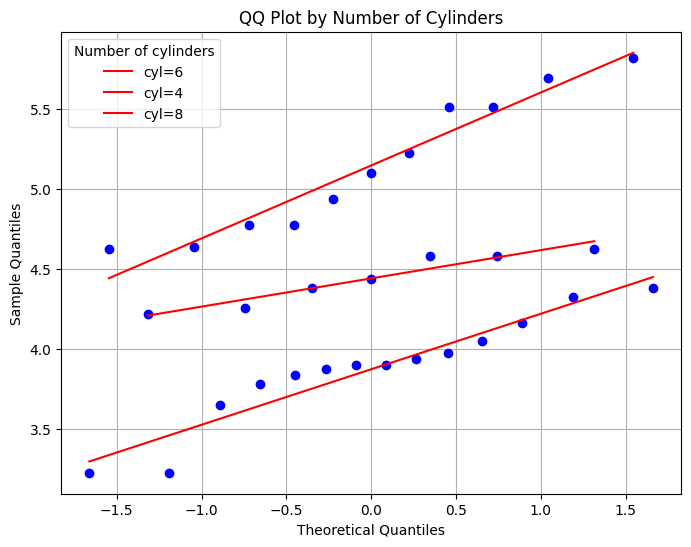

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Create a QQ plot with QQ line
plt.figure(figsize=(8, 6))
for cyl in mtcars['cyl'].unique():
    subset = mtcars[mtcars['cyl'] == cyl]
    stats.probplot(subset['mpg'], dist="norm", plot=plt)
    plt.gca().get_lines()[-1].set_label(f'cyl={cyl}')

plt.legend(title='Number of cylinders')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('QQ Plot by Number of Cylinders')
plt.grid(True)
plt.show()

We cannot see any deviations from normality line, p-values also suggest no rejection. 

Next, let's test the assumption about the homogeneity of variances. I highly recommend Levene’s test, which is less sensitive to departures from normal distribution. 

In [5]:
import pandas as pd
from scipy.stats import levene

# Load the mtcars dataset
url = "https://raw.githubusercontent.com/selva86/datasets/master/mtcars.csv"
mtcars = pd.read_csv(url)
mtcars['cyl'] = mtcars['cyl'].astype(str)

# Perform Levene's test for equal variances
stat, p_value = levene(mtcars[mtcars['cyl'] == '4']['mpg'],
                       mtcars[mtcars['cyl'] == '6']['mpg'],
                       mtcars[mtcars['cyl'] == '8']['mpg'])

print(f"Levene's test statistic: {stat}")
print(f"p-value: {p_value}")

Levene's test statistic: 2.868889131775262
p-value: 0.07296950644913473


P-value is only a little bit higher than our threshold alpha=0.05, so if you would like to run more robust Anova => Welch's Anova, run the function from pingouin library:

*welch_anova_results = pg.welch_anova(dv='mpg', between='cyl', data=mtcars)*

## Finally, let's calculate the ANOVA table (with equal variances):

In [6]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Perform ANOVA using statsmodels
model = ols('mpg ~ cyl', data=mtcars).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

# Display the ANOVA table
print(anova_results)

             sum_sq    df          F        PR(>F)
cyl       10.013559   2.0  41.055426  3.477779e-09
Residual   3.536600  29.0        NaN           NaN


## As we can see, at least one pair of means is significantly different (H0 should be rejected). It means that miles per gallon significantly differs in cars with different number of cylinders. 

Now, in case of H0 rejection, we can perform the post-hoc LSD (least-significant-differences) or HSD (honestly-significant-differences) tests. Tukey HSD, used to compare all groups to each other (so all possible comparisons of 2 groups).

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     4      6  -0.7064 0.0007 -1.1234 -0.2894   True
     4      8   -1.275    0.0 -1.6224 -0.9275   True
     6      8  -0.5686  0.004 -0.9678 -0.1693   True
----------------------------------------------------


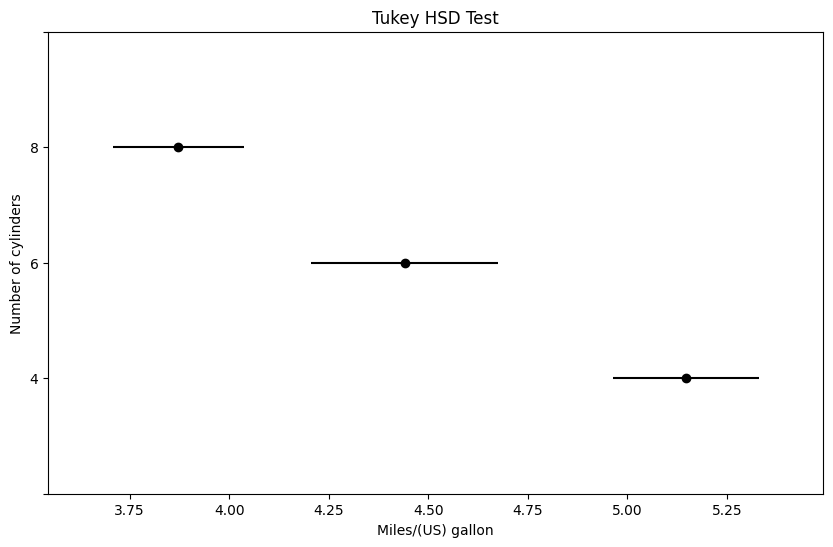

In [7]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt

# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=mtcars['mpg'], groups=mtcars['cyl'], alpha=0.05)

# Print the results
print(tukey)

# Plot the results
tukey.plot_simultaneous()
plt.title('Tukey HSD Test')
plt.xlabel('Miles/(US) gallon')
plt.ylabel('Number of cylinders')
plt.show()

## As we can see above, all pairs of means are significantly different (p<alfa).

Finally, let's visualize our results together with Anova test and its post-hoc tests:

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     4      6  -0.7064 0.0007 -1.1234 -0.2894   True
     4      8   -1.275    0.0 -1.6224 -0.9275   True
     6      8  -0.5686  0.004 -0.9678 -0.1693   True
----------------------------------------------------


C:\Users\rgfif\AppData\Local\Temp\ipykernel_23864\3144271967.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cyl', y='mpg', data=mtcars, palette="Set3")
C:\Users\rgfif\AppData\Local\Temp\ipykernel_23864\3144271967.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  anova_text = (f"ANOVA F-value: {anova_results['F'][0]:.2f}\n"
C:\Users\rgfif\AppData\Local\Temp\ipykernel_23864\3144271967.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"ANOVA p-value: {anova

Text(0.5, 0.95, 'ANOVA F-value: 41.06\nANOVA p-value: 0.000')

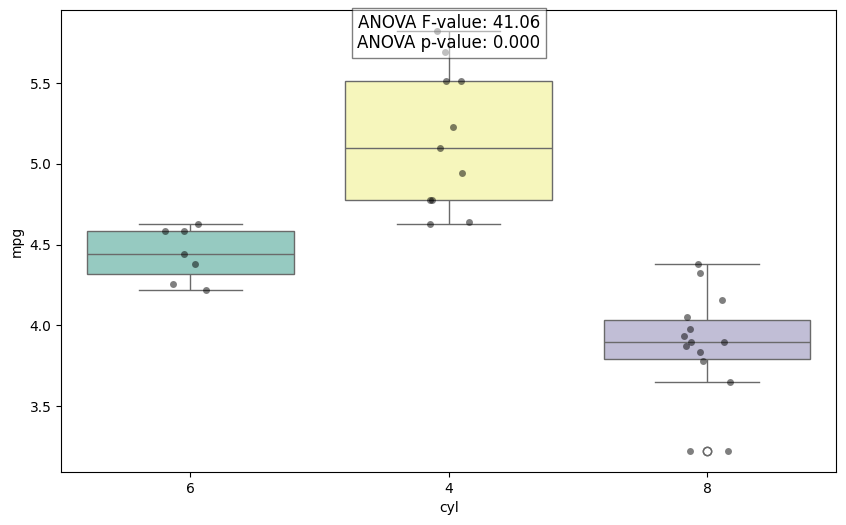

In [8]:
# Perform Tukey's HSD test
tukey = pairwise_tukeyhsd(endog=mtcars['mpg'], groups=mtcars['cyl'], alpha=0.05)
print(tukey)

# Plot the results using seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='cyl', y='mpg', data=mtcars, palette="Set3")
sns.stripplot(x='cyl', y='mpg', data=mtcars, color='black', jitter=True, alpha=0.5)

# Annotate the plot with ANOVA results
anova_text = (f"ANOVA F-value: {anova_results['F'][0]:.2f}\n"
              f"ANOVA p-value: {anova_results['PR(>F)'][0]:.3f}")
plt.text(0.5, 0.95, anova_text, horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

DIY: 

What about **am, number of gears**? 

In [35]:
from scipy.stats import f_oneway
# Podział danych na grupy
group_auto = mtcars[mtcars['am'] == 0]['mpg']
group_manual = mtcars[mtcars['am'] == 1]['mpg']

# 1. Test Normalności (Shapiro-Wilk) dla każdej grupy osobno
print("Normalność Auto:", stats.shapiro(group_auto).pvalue)
print("Normalność Manual:", stats.shapiro(group_manual).pvalue)
# Jeśli p-value > 0.05 -> rozkład jest normalny (OK)

# 2. Test Równości Wariancji (Levene)
stat, p_levene = stats.levene(group_auto, group_manual)
print(f"Test Levene'a (p-value): {p_levene}")
# Jeśli p-value > 0.05 -> wariancje są równe (OK)

f_stat_am, p_val_am = stats.f_oneway(group_auto, group_manual)
print(f"ANOVA dla AM: p-value = {p_val_am}")


tukey = pairwise_tukeyhsd(endog=mtcars['mpg'], groups=mtcars['am'], alpha=0.05)
print(tukey)



Normalność Auto: 0.7954711572354922
Normalność Manual: 0.5504525228632942
Test Levene'a (p-value): 0.18383615859268518
ANOVA dla AM: p-value = 0.0003464507183018984
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower  upper  reject
--------------------------------------------------
     0      1   0.7859 0.0003 0.3882 1.1836   True
--------------------------------------------------


In [36]:
group_gear_3 = mtcars[mtcars['gear']==3]['mpg']
group_gear_4 = mtcars[mtcars['gear']==4]['mpg']
group_gear_5 = mtcars[mtcars['gear']==5]['mpg']

# 1. Test Normalności (Shapiro-Wilk) dla każdej grupy osobno
print("Normalność gear 3:", stats.shapiro(group_gear_3).pvalue)
print("Normalność gear 4:", stats.shapiro(group_gear_4).pvalue)
print("Normalność gear 5:", stats.shapiro(group_gear_5).pvalue)
# Jeśli p-value > 0.05 -> rozkład jest normalny (OK)

# 2. Test Równości Wariancji (Levene)
stat, p_levene = stats.levene(group_gear_3, group_gear_4, group_gear_5)
print(f"Test Levene'a (p-value): {p_levene}")
# Jeśli p-value > 0.05 -> wariancje są równe (OK)


f_stat_am, p_val_am = stats.f_oneway(group_gear_3, group_gear_4, group_gear_5)
print(f"ANOVA dla gear: p-value = {p_val_am}")

tukey = pairwise_tukeyhsd(endog=mtcars['mpg'], groups=mtcars['gear'], alpha=0.05)
print(tukey)

Normalność gear 3: 0.5414082198424401
Normalność gear 4: 0.320853371652283
Normalność gear 5: 0.49696475264756973
Test Levene'a (p-value): 0.4016981963813906
ANOVA dla gear: p-value = 0.00022221079877553929
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     3      4   0.9359 0.0002  0.4467 1.4251   True
     3      5   0.5879 0.0836 -0.0644 1.2401  False
     4      5  -0.3481 0.4183 -1.0204 0.3243  False
---------------------------------------------------


## two way

Shapiro-Wilk p-value: 0.5192759048957585
Levene p-value: 0.2770836588714732
      Source          SS    DF          MS            F         p-unc  \
0         am    6.083414   1.0    6.083414    24.849191  2.890275e-05   
1       gear  509.841302   2.0  254.920651  1041.285707  5.231325e-27   
2  am * gear  126.203924   2.0   63.101962   257.755386  9.274665e-19   
3   Residual    6.854774  28.0    0.244813          NaN           NaN   

        np2  
0  0.470191  
1  0.986733  
2  0.948483  
3       NaN  


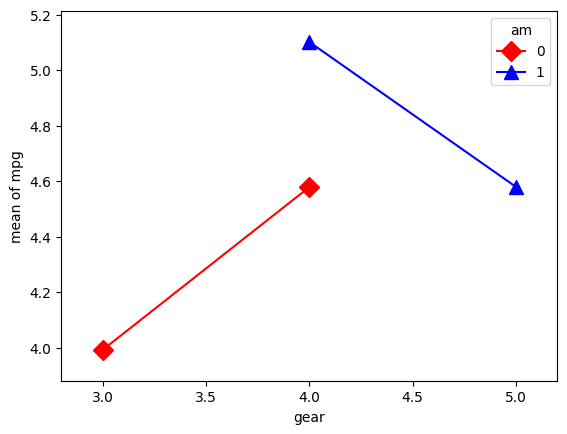

In [43]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from pingouin import anova
from statsmodels.graphics.factorplots import interaction_plot

# 1. Budujemy model Two-Way ANOVA
# Pamiętaj: C() oznacza, że traktujemy zmienną jako kategorię
model = ols('mpg ~ C(am) + C(gear) + C(am):C(gear)', data=mtcars).fit()

# 2. Wyciągamy reszty (błędy)
residuals = model.resid

# 3. Robimy test Shapiro-Wilka na resztach
stat, p_value = stats.shapiro(residuals)

print(f"Shapiro-Wilk p-value: {p_value}")

# 1. Tworzymy kolumnę "kombinowaną" (np. "0_3", "1_4")
# Żebyśmy mieli unikalne grupy dla każdej pary am+gear
mtcars['group_combo'] = mtcars['am'].astype(str) + '_' + mtcars['gear'].astype(str)

# 2. Grupujemy dane według tej nowej kolumny
# To tworzy listę tablic, którą łyknie funkcja levene
groups_list = [mtcars[mtcars['group_combo'] == g]['mpg'] for g in mtcars['group_combo'].unique()]

# 3. Test Levene'a
stat, p_value = stats.levene(*groups_list)

print(f"Levene p-value: {p_value}")


anova_results = anova(data=mtcars, dv='mpg', between=['am','gear'])
print(anova_results)

fig = interaction_plot(
    x=mtcars['gear'],      # Oś X: jedna z kategorii (Biegi)
    trace=mtcars['am'],    # Linie: druga z kategorii (Skrzynia)
    response=mtcars['mpg'],# Oś Y: wynik (Spalanie - to co badamy!)
    colors=['red', 'blue'],
    markers=['D', '^'],
    ms=10
)

plt.show()

# Your turn!

The following dataset contains the job satisfaction score organized by gender and education level.

In this study, a researcher wants to evaluate if there is a significant two-way interaction between gender and education_level on explaining the job satisfaction score.

An **interaction effect** occurs when the effect of one independent variable on an outcome variable depends on the level of the other independent variables. If an interaction effect does not exist, main effects could be reported.



                     Source          SS    DF         MS           F  \
0                    gender    0.225297   1.0   0.225297    0.744721   
1           education_level  113.684117   2.0  56.842059  187.892103   
2  gender * education_level    4.439794   2.0   2.219897    7.337895   
3                  Residual   15.731300  52.0   0.302525         NaN   

          p-unc       np2  
0  3.921154e-01  0.014119  
1  1.600455e-24  0.878443  
2  1.559245e-03  0.220107  
3           NaN       NaN  


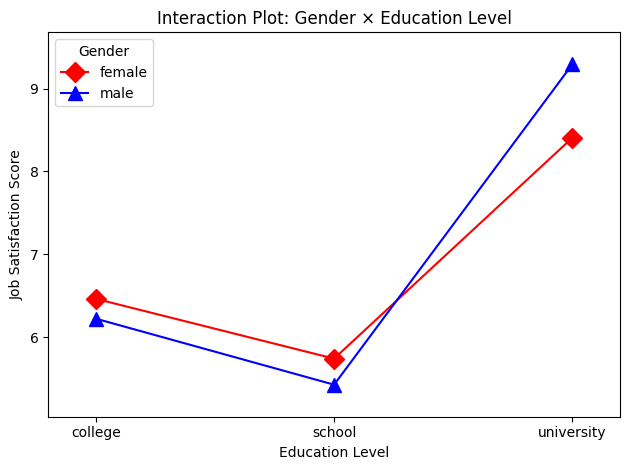

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.factorplots import interaction_plot
from pingouin import anova

# Load the jobsatisfaction dataset
url = "https://raw.githubusercontent.com/kflisikowski/ds/master/jobsatisfaction.csv"
jobsatisfaction = pd.read_csv(url)

# Two-way ANOVA
anova_results = anova(data=jobsatisfaction, dv='score', between=['gender','education_level'])
print(anova_results)

# Interaction plot
fig = interaction_plot(
    x=jobsatisfaction['education_level'],  # x-axis variable
    trace=jobsatisfaction['gender'],        # trace factor (different lines)
    response=jobsatisfaction['score'],      # y-axis (response variable)
    colors=['red', 'blue'],
    markers=['D', '^'],
    ms=10
)

plt.xlabel('Education Level')
plt.ylabel('Job Satisfaction Score')
plt.title('Interaction Plot: Gender × Education Level')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()